# Trabajo Práctico N° 4
## Inferencia Bayesiana con métodos MonteCarlo: Cadenas de Markov

En este trabajo práctico implementaremos distintos conceptos y técnicas estudiados, relacionados con la infer-
encia estadı́stica, ajuste de funciones, selección de modelos, cuadrados mı́nimos, interpolación y minimización. Las
actividades a realizar son:


+ Inferencia Bayesiana, para realizar el ajuste de un modelo paramétrico a un conjunto de datos.
+ Exploración del espacio de parámetros para estimar la función de Likelihood usando Cadenas de Markov Monte
Carlo (MCMC).
+ Implementación del algoritmo de Metrópolis-Hastings para llevar a cabo realizaciones de MCMC.
+ Interpolación de datos para construir una función contı́nua y derivable que pase por un conjunto de puntos.
+ Minimización de funciones, mediante la técnica del gradiente descendente.
+ Implementación de funciones en Python

### Inciso 1

Leer y graficar los datos pertenecientes a la función de luminosidad de galaxias obtenida por Blanton et al.
(2001). La figura de interés se reproduce a continuación. Los datos correspondientes a la función de luminosidad
se pueden obtener usando la página https://automeris.io/WebPlotDigitizer/ con una captura de pantalla del paper de la publicación.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy import random
import functools
import scipy.stats as st

In [2]:
data = np.genfromtxt('puntos')
data_inf = np.genfromtxt('puntos inferiores')
data_sup = np.genfromtxt('puntos superiores')

In [3]:
print(len(data),len(data_inf),len(data_sup))

47 47 47


In [4]:
x_lista = []
y_lista = []
y_lista_inf = []
y_lista_sup = []

for i in range(len(data)):
    x = data[i][0]
    y = data[i][1]
    y_inf = data_inf[i][1]
    y_sup = data_sup[i][1]
    x_lista.append(x)
    y_lista.append(y) 
    y_lista_sup.append(y_sup)
    y_lista_inf.append(y_inf)

In [5]:
barra_y_sup = np.array(y_lista_sup)
barra_y_inf = np.array(y_lista_inf)
barra_y = np.array(y_lista)

In [6]:
barra_sup = barra_y_sup - barra_y
barra_inf = barra_y - barra_y_inf

In [7]:
barras = [barra_inf, barra_sup] 

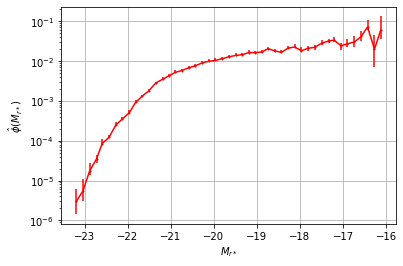

In [8]:
plt.scatter(x_lista,y_lista, s=1, c = 'red')
plt.errorbar(x_lista, y_lista, yerr=barras, c = 'red')
plt.yscale('log')
plt.ylabel('$\hat{\phi} (M_{r*})$')
plt.xlabel('$M_{r*}$')
plt.grid()

### Inciso 

Se desea ajustar el modelo m al conjunto de datos d, mediante un análisis Bayesiano. Para el caso de los
datos del Ej. 1, se utilizará como modelo la función de Schechter:


<center> 
$\phi$(M) dM = 0.4 $ln$(10) $\phi_*$ $10^{-0.4(M-M_*)(\alpha+1)}$ exp($10^{-0.4(M-M_*)}$)
</center>

Los parámetros que se intentan determinar son φ ∗ , M ∗ y α. Para ello, escribir en python las siguientes funciones:

+ La función de likelihood

+ La función de priors

+ La función de probabilidad posterior


La idea es maximizar la probabilidad de tener los parámetros $\theta$ ($\phi_*$,$M_*$ y $\alpha_*$), dados el modelo m (la función de luminosidad de las galaxias del Sloan Digital Sky Survey en la banda r y d) y los datos d extraidos del paper mencionado antes.
Por el teorema de Bayes, sabemos que:
<center>
    
</center>

<center>
$P(\theta|d,m) = \frac{P(d|\theta,m)P(\theta|m)}{P(d|m)}$
</center>

donde:
+ $P(\theta|d,m)$: “Probabilidad a posteriori” de los parámetros dados los datos y el modelo
+ $P(d|\theta, m)$: Función de likelihood $P(d|\theta, m) = L(d|\theta, m)$. Considerando algún modelo de error, nos dice qué tan bien reproducen los datos a las predicciones del modelo.
+ $P(\theta|m)$: “Probabilidad a priori o priors” para los parámetros (es lo que sabemos de antemano). Nos habla de los valores permitidos para los parámetros de este modelo - conocimiento previo.
+ $P(d|m)$: “Evidencia”, constante de normalización, $P(d|m) = \int_{\theta} P(d|\theta, m) P (\theta|m) d\theta$. Nos dice qué tan bien el modelo ajusta los datos. La integral que define la “Evidencia” es muy costosa computacionalmente, pero hay ciertas técnicas que se emplean, como el MCMC. la Evidencia sólo tiene sentido cuando se comparan modelos con arquitecturas muy distintas.

Por lo tanto, los parámetros se buscan haciendo
<center>
$max_{\theta}P(d|\theta,m) P(\theta|m) = max_{\theta} \frac{P(d|\theta,m)P(\theta|m)}{\int_{\theta} P(d|\theta, m) P(\theta|m) d\theta}$
</center>
Esto es lo que se conoce como FULL BAYES (esta ecuación es muy trabajosa porque hay que poner explı́citamente priors en cada parámetro utilizado). Si nos quedamos con una sola arquitectura (fijamos m), se simplifican las cuentas y podemos escribir el “Máximo a posteriori” (MAP) como:
<center>    
$max_{\theta}P(\theta|d) = max_{\theta}\frac{P(d|\theta)P(\theta)}{P(d)} $
</center>

Ahora, $P(d)$ sólo se usa si tenemos que combinar distintos conjuntos de datos (por
ejemplo, datos de diferentes catálogos). Por lo tanto, si asumimos $P(d) = 1$ y además
un prior uniforme ($P(φ) = 1$), nos queda el “Máximo Likelyhood”:
<center>
$max_{theta} P(\theta|d) = max_{\theta} P(d|\theta)$
</center>
Ésta es la clase más simple para la estimación de modelos.

In [9]:
def modelo(phi0,X,M0,alpha):
    
    modelo_lista = []
    A = np.array(X)
    
    for i in range(len(A)):
        C = (-0.4) * (A[i]-M0) * (alpha+1)
        B = (-0.4) * (A[i]-M0)
        phi = 0.4 * np.log(10) * phi0 * (10**C) * np.exp(-10**B)
        modelo_lista.append(phi)
    return(modelo_lista)

In [190]:
y = modelo(1.46e-2,x_lista,-20.83,-1.20)

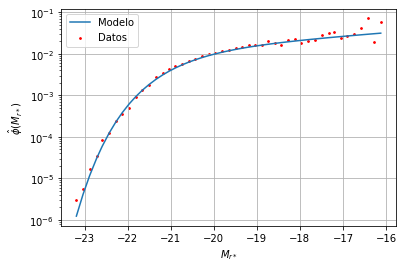

In [11]:
plt.plot(x_lista,y,label='Modelo')
plt.yscale('log')
plt.scatter(x_lista,y_lista, s=3, c = 'red',label='Datos')
#plt.errorbar(x_lista, y_lista, yerr=barras, c = 'red')
plt.ylabel('$\hat{\phi} (M_{r*})$')
plt.xlabel('$M_{r*}$')
plt.legend()
plt.grid()

+ Calculamos el Likelihood

In [12]:
def likelihood(X,Y,sigma,a,b,c):
    y_modelo = modelo(a,X,b,c)
    lista_likelihood = []
    for i in range(len(X)):
        p = norm.pdf(Y[i],y_modelo[i],sigma[i])
        lista_likelihood.append(p)
        
    return(np.prod(lista_likelihood))

In [13]:
intervalo_lista = []

for i in range(len(barra_y_sup)):
    intervalo = (barra_sup[i] + barra_inf[i])*0.5
    intervalo_lista.append(intervalo)

In [14]:
likelihood(x_lista,y_lista,intervalo_lista,1.46e-2,-20.83,-1.20)

2.908342530234035e+120

+ Ahora calculamos la probabilidad a priori o priors. COmenzamos armando una función que nos lo permita calcular ingresados los parámetros.

In [15]:
def prior1(phi=1.46e-2,a=-1.2, M=-20.83,phi_inf =9e-3,phi_sup=2.4E-2,a_sup=-0.9,a_inf=-1.5,M_sup=-20.55,M_inf=-21.1):
    
    delta_phi = phi_sup - phi_inf
    delta_alpha = a_sup -a_inf
    delta_M = M_sup - M_inf
#     recordar que deben ser positivos los scale, o arreglarlo con abs()
    f = st.uniform(loc = [ phi_inf, a_inf, M_inf], scale = [delta_phi, delta_alpha, delta_M])
    p = f.pdf([phi, a, M]).prod()
#     esto porque debemos hacer el producto de los 1 / scale(i), que me da el volumen
# los _inf y _sup son los limites inferiores y superiores de los parametros, el uniform se centra en el _inf, 
# con scale = amplitud del intervalo de cada parametro
# phi, a y M son los valores que queremos probar si se encuentran dentro del cubo de parametros
    return(p)

Para darle valores de $M_{max}$, $M_{min}$, $\phi_{max}$, $\phi_{min}$, $\alpha_{max}$, $\alpha_{min}$ tenemos que definir límites de la función a ojo, ya que no tenemos información de Galaxias como para inferir cuales podrían ser.

In [16]:
#phi_max = 2.4e-2
#phi_min = 9e-3
#M_max = -21.1
#M_min = -20.55
#alpha_max = -1.5
#alpha_min = -0.9

#valores propuestos por pato

phi_max = 4e-3
phi_min = 4e-4
M_max = -19.9
M_min = -21.9
alpha_max = -1.9
alpha_min = -1e-4

y = modelo(1.46e-2,x_lista,-20.83,-1.20)
y1 = modelo(phi_max,x_lista,-20.83,-1.20)
y2 = modelo(phi_min,x_lista,-20.83,-1.20)
y3 = modelo(1.46e-2,x_lista,M_max,-1.20)
y4 = modelo(1.46e-2,x_lista,M_min,-1.20)
y5 = modelo(1.46e-2,x_lista,-20.83,alpha_max)
y6 = modelo(1.46e-2,x_lista,-20.83,alpha_min)

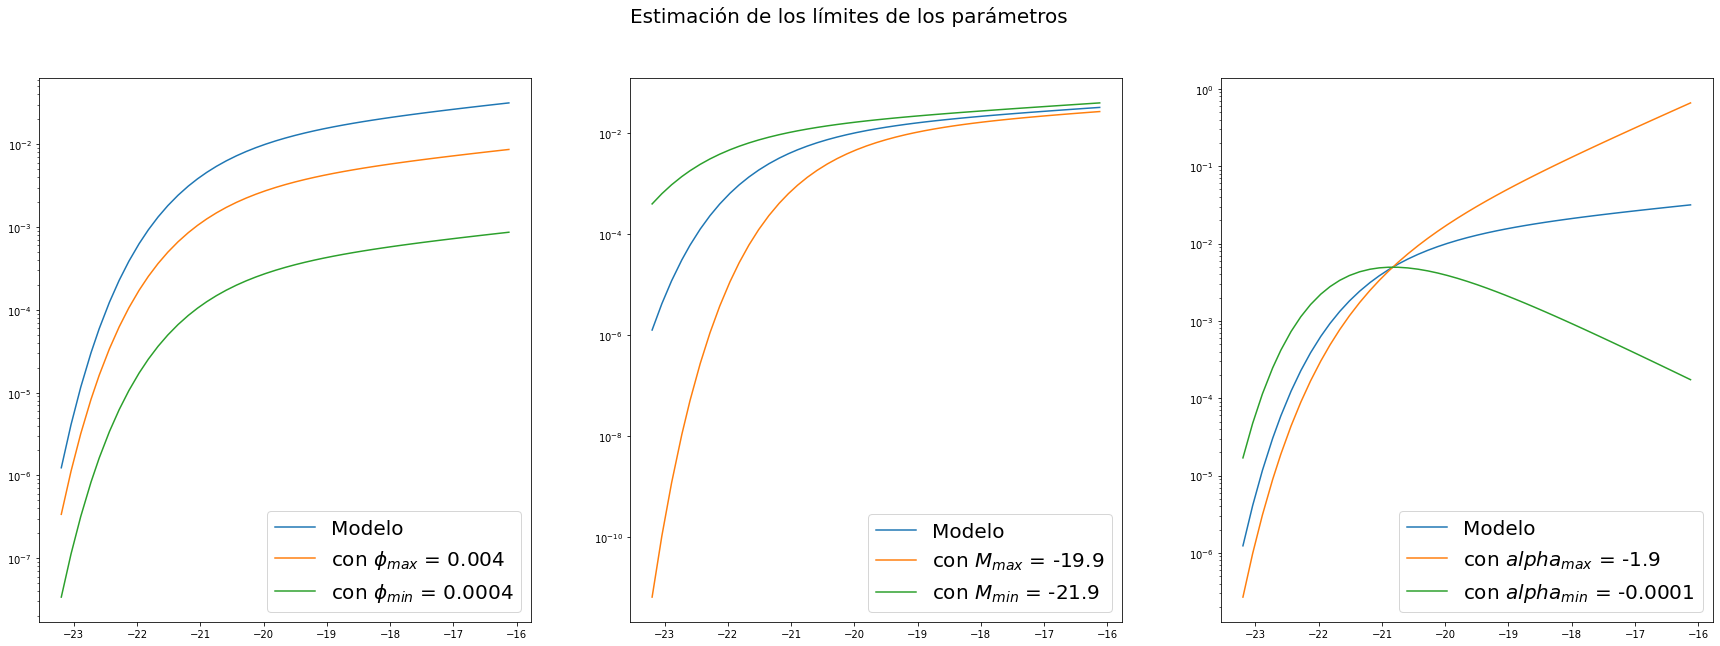

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Estimación de los límites de los parámetros', fontsize=20)

ax1.plot(x_lista,y,label='Modelo')
ax1.plot(x_lista,y1,label='con $\phi_{max}$ = '+str(phi_max))
ax1.plot(x_lista,y2,label='con $\phi_{min}$ = '+str(phi_min))
ax1.set_yscale('log')
ax1.legend(loc = 'lower right',fontsize=20)

ax2.plot(x_lista,y,label='Modelo')
ax2.plot(x_lista,y3,label='con $M_{max}$ = '+str(M_max))
ax2.plot(x_lista,y4,label='con $M_{min}$ = '+str(M_min))
ax2.set_yscale('log')
ax2.legend(loc = 'lower right',fontsize=20)

ax3.plot(x_lista,y,label='Modelo')
ax3.plot(x_lista,y5,label = 'con $alpha_{max}$ = '+str(alpha_max))
ax3.plot(x_lista,y6,label = 'con $alpha_{min}$ = '+str(alpha_min))
ax3.set_yscale('log')
ax3.legend(loc = 'lower right',fontsize=20)

fig.subplots_adjust(wspace=0.2)
plt.show()

In [18]:
prior1(phi=1.46e-2,a=-1.2, M=-20.83,phi_inf = 0.0004, phi_sup = 0.04, a_inf = -1.9, a_sup = -0.0001, M_inf = -21.9, M_sup = -19.7)

6.041591962382053

In [19]:
prior2b = functools.partial(prior1,phi_inf = 0.0004, phi_sup = 0.04, a_inf = -1.9, a_sup = -0.0001, M_inf = -21.9, M_sup = -19.7)

In [20]:
prior2b(phi=1.46e-2,a=-1.2, M=-20.83)

6.041591962382053

In [21]:
def posterior(x_lista,y_lista,intervalo_lista,phi0,M0,alpha0):
    p = likelihood(x_lista,y_lista,intervalo_lista,phi0,M0,alpha0)
    q = prior2b(phi0,alpha0, M0)
    return(q*p)

In [22]:
posterior(x_lista,y_lista,intervalo_lista,1.46e-2,-20.83,-1.20)

1.7571018854515828e+121

### Inciso 3

Visualizar las propiedades de convergencia de las cadenas. Encontrar condiciones de la simulación para las
cuales se produce un mal y un buen mezclado (mixing) de las cadenas. Para ello realize varias cadenas y compárelas.
Sugerencia: Se pueden realizar los siguietes gráficos:


+ Likelihood vs. valor de un parámetro

+ valor de un parámetro vs. eslabón de la cadena

+ Distribución marginal de los valores de un parámetro (en este caso tener en cuenta que la cadena sea ”estable”)

+ Curvas de nivel de la función de Likelihood.

+ Máxima separación entre cadenas como función del número de pasos. Para esto es necesario contar con varias
cadenas independientes, inicializadas con posiciones aleatorias de acuerdo a los priors

<center>
</center>
    
    
Antes de empezar con las cadenas, construimos la proposal distribution. Esta será la que definirá el salto de cada parámetro para construir la cadena.

In [23]:
def d_propuesta(M0, phi0, alpha0):

    c1 = 0.02
    c2 = 0.0002
    c3 = 0.02
    
    d1 = random.normal(loc=M0, scale=(c1))
    d2 = random.normal(loc=phi0, scale=(c2))
    d3 = random.normal(loc=alpha0, scale=(c3))

    return([d1, d2, d3])

In [24]:
d_propuesta(-20.83, 1.46e-2, -1.2)

[-20.811553553607567, 0.014888134219482142, -1.1893020421090221]

In [25]:
#iniciamos la cadena
post = 0

while post < 1e-8:
    
    M0 = random.uniform(-21.9,-19.1)
    phi0 = random.uniform(4e-4,4e-2)
    alpha0 = random.uniform(-1.9,-1e-4)
    
    #print(M0,phi0,alpha0)

    post = posterior(x_lista,y_lista,intervalo_lista,phi0,M0,alpha0)

    prob_posterior = post

pasos = 9e+3
pasos = int(pasos)

cadena_M = []
cadena_phi = []
cadena_alpha = []

for i in range(pasos):
    salto = d_propuesta(M0, phi0, alpha0)
    
    M_n = salto[0]
    phi_n = salto[1]
    alpha_n = salto[2]
    
    prob_posterior_n = posterior(x_lista,y_lista,intervalo_lista,phi_n,M_n,alpha_n)
    
    #print(prob_posterior)
    prob_aceptacion = min(1,(prob_posterior_n/prob_posterior))
    u = random.uniform()
    
    if u < prob_aceptacion:
        M0 = M_n
        alpha0 = alpha_n
        phi0 = phi_n
        prob_posterior = prob_posterior_n
    
    cadena_M.append(M0)
    cadena_phi.append(phi0)
    cadena_alpha.append(alpha0)
    #print(cadena_alpha)

Realizamos los siguientes gráficos:
+ Gráfico de parámetro vs parámetro
+ Valor del parámetro por pasos
+ Histograma de cada parámetro


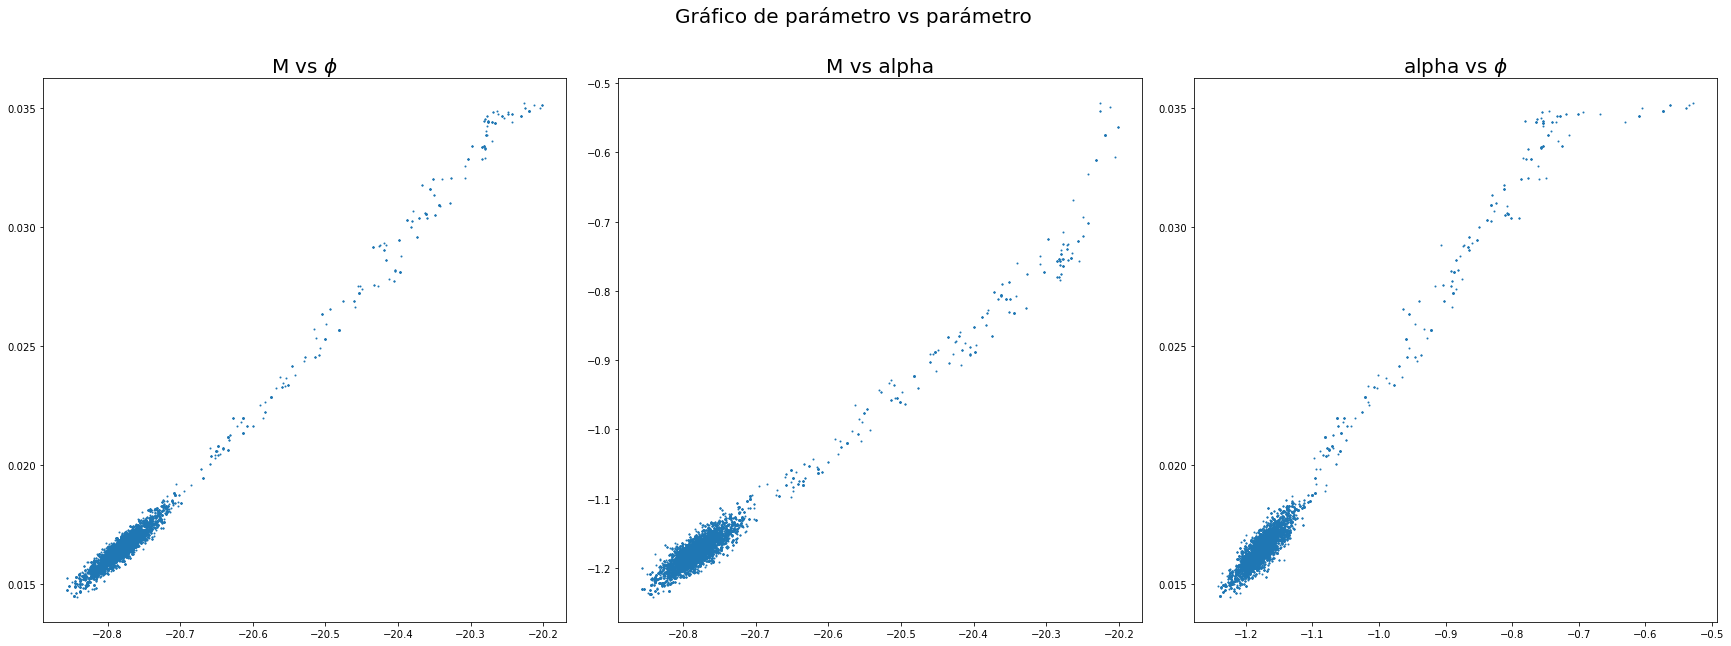

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Gráfico de parámetro vs parámetro', fontsize=20)


ax1.scatter(cadena_M, cadena_phi,s=1)
ax1.set_title('M vs $\phi$', fontsize = 20)

ax2.scatter(cadena_M, cadena_alpha,s=1)
ax2.set_title('M vs alpha', fontsize = 20)

ax3.scatter(cadena_alpha, cadena_phi,s=1)
ax3.set_title('alpha vs $\phi$', fontsize = 20)


fig.subplots_adjust(wspace=0.1)
plt.show()

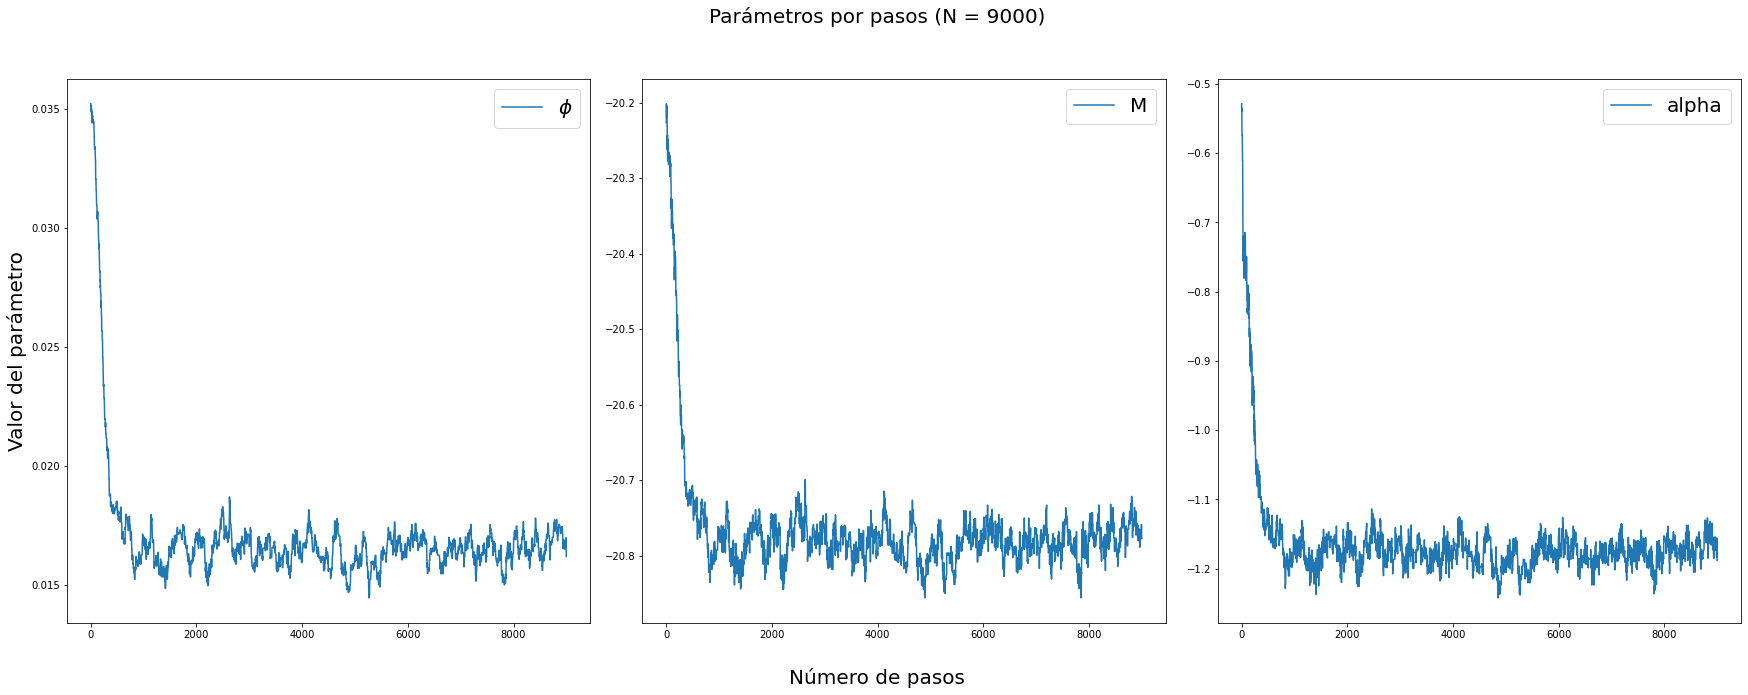

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Parámetros por pasos (N = 9000)', fontsize=20)


ax1.plot(cadena_phi, label = '$\phi$')
ax1.legend(loc = 'upper right',fontsize=20)
ax1.set_ylabel('Valor del parámetro', fontsize = 20)

ax2.plot(cadena_M, label = 'M')
ax2.legend(loc = 'upper right',fontsize=20)

ax3.plot(cadena_alpha, label = 'alpha')
ax3.legend(loc = 'upper right',fontsize=20)

fig.text(0.5, 0.04, 'Número de pasos', ha='center',fontsize=20)
fig.subplots_adjust(wspace=0.1)
plt.show()

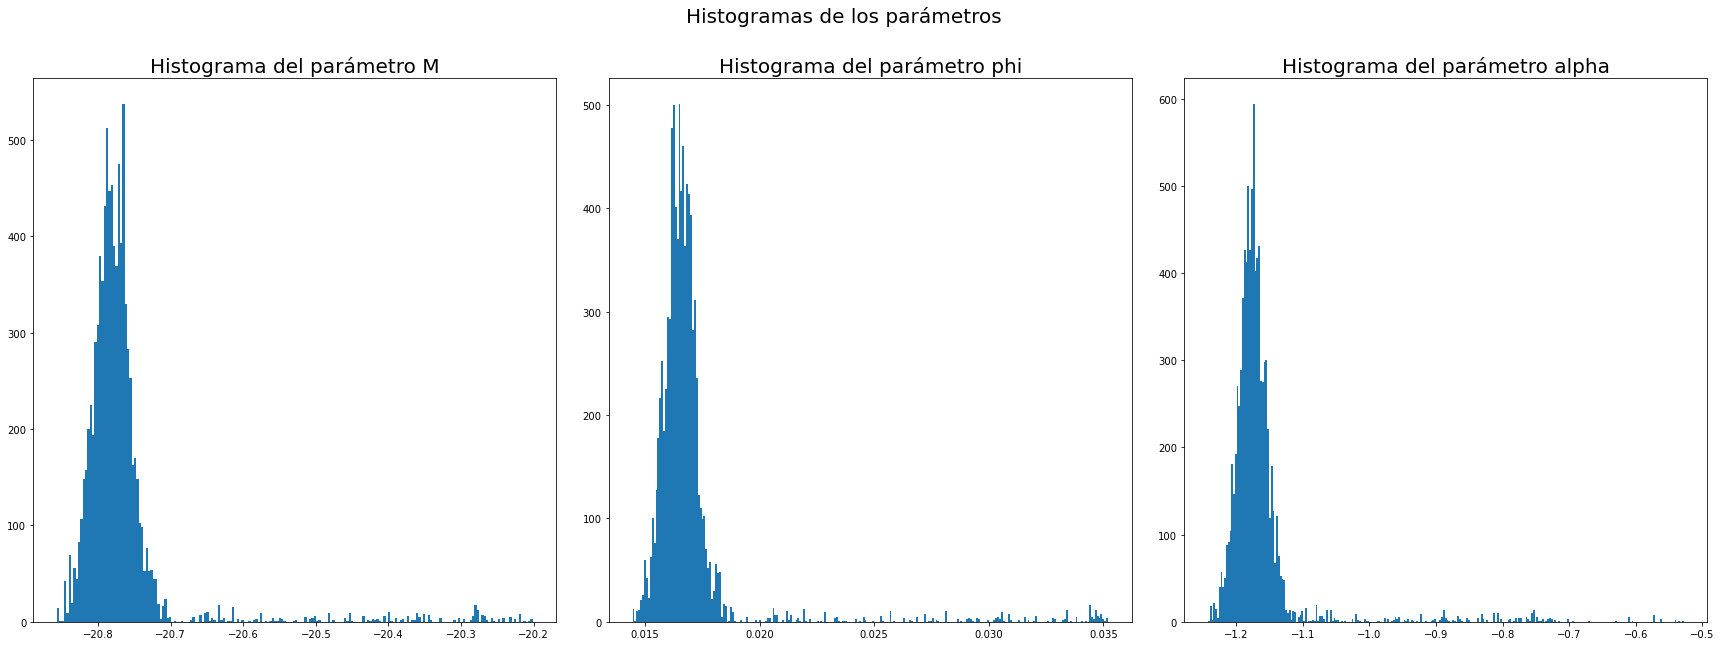

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Histogramas de los parámetros', fontsize=20)

ax1.hist(cadena_M, bins = 'fd')
ax1.set_title('Histograma del parámetro M', fontsize = 20)

ax2.hist(cadena_phi, bins = 'fd')
ax2.set_title('Histograma del parámetro phi', fontsize = 20)

ax3.hist(cadena_alpha, bins = 'fd')
ax3.set_title('Histograma del parámetro alpha', fontsize = 20)

fig.subplots_adjust(wspace=0.1)
plt.show()

Las cadenas parecen converger bien a primera vista

### Inciso 4

Para una elección de parámetros que produzca un buen mezclado, correr varias cadenas y compararlas.

Elejimos correr 10 cadenas con 2000 pasos y graficar las primeras tres. Para esto modificamos el código anterior, agregándo las líneas necesarias para esto.



In [31]:
listas_M = []
listas_phi = []
listas_alpha = []
lista_likelihood = []

n_cadenas = 10

pasos = 2e+3
pasos = int(pasos)

for i in range(n_cadenas):

    #iniciamos la cadena
    post = 0

    while post < 1e-8:

        M0 = random.uniform(-21.9,-19.1)
        phi0 = random.uniform(4e-4,4e-2)
        alpha0 = random.uniform(-1.9,-1e-4)

        #print(M0,phi0,alpha0)

        post = posterior(x_lista,y_lista,intervalo_lista,phi0,M0,alpha0)

        prob_posterior = post



    cadena_M = []
    cadena_phi = []
    cadena_alpha = []
    cadena_l = []
    

    for i in range(pasos):
        salto = d_propuesta(M0, phi0, alpha0)

        M_n = salto[0]
        phi_n = salto[1]
        alpha_n = salto[2]

        prob_posterior_n = posterior(x_lista,y_lista,intervalo_lista,phi_n,M_n,alpha_n)

        #print(prob_posterior)
        prob_aceptacion = min(1,(prob_posterior_n/prob_posterior))
        u = random.uniform()

        if u < prob_aceptacion:
            M0 = M_n
            alpha0 = alpha_n
            phi0 = phi_n
            prob_posterior = prob_posterior_n

        cadena_M.append(M0)
        cadena_phi.append(phi0)
        cadena_alpha.append(alpha0)
        
        li = likelihood(x_lista,y_lista,intervalo_lista,phi0,M0,alpha0)
        cadena_l.append(li)
        
    listas_M.append(cadena_M)
    listas_phi.append(cadena_phi)
    listas_alpha.append(cadena_alpha)
    lista_likelihood.append(cadena_l)

In [32]:
len(lista_likelihood)

10

Primero calculamos el parámetro por paso promediado sobre las 10 cadenas

Text(0.5, 0, 'Número de pasos')

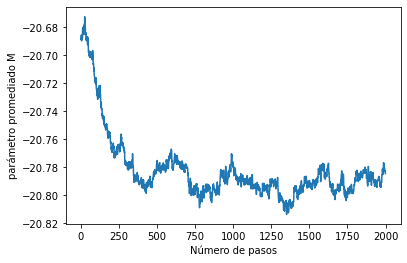

In [33]:
M_prom_l = []

for i in range(2000):
    suma = 0
    
    for j in range(n_cadenas):
        suma = suma + listas_M[j][i]
    
    prom_del_paso = suma/n_cadenas
    
    M_prom_l.append(prom_del_paso)
    

plt.plot(range(2000),M_prom_l)
plt.ylabel('parámetro promediado M')
plt.xlabel('Número de pasos')

Text(0.5, 0, 'Número de pasos')

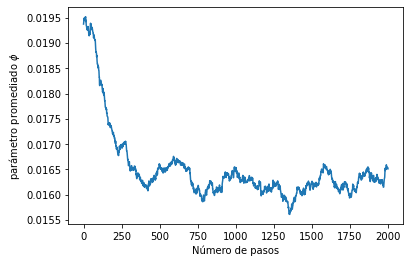

In [34]:
M_prom_l = []

for i in range(2000):
    suma = 0
    
    for j in range(n_cadenas):
        suma = suma + listas_phi[j][i]
    
    prom_del_paso = suma/n_cadenas
    
    M_prom_l.append(prom_del_paso)
    

plt.plot(range(2000),M_prom_l)
plt.ylabel('parámetro promediado $\phi$')
plt.xlabel('Número de pasos')

Text(0.5, 0, 'Número de pasos')

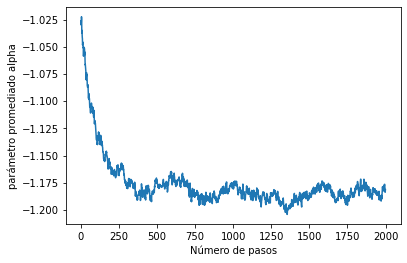

In [35]:
M_prom_l = []

for i in range(2000):
    suma = 0
    
    for j in range(n_cadenas):
        suma = suma + listas_alpha[j][i]
    
    prom_del_paso = suma/n_cadenas
    
    M_prom_l.append(prom_del_paso)
    

plt.plot(range(2000),M_prom_l)
plt.ylabel('parámetro promediado alpha')
plt.xlabel('Número de pasos')

Graficamos 3 cadenas para ver como cambian los resultados

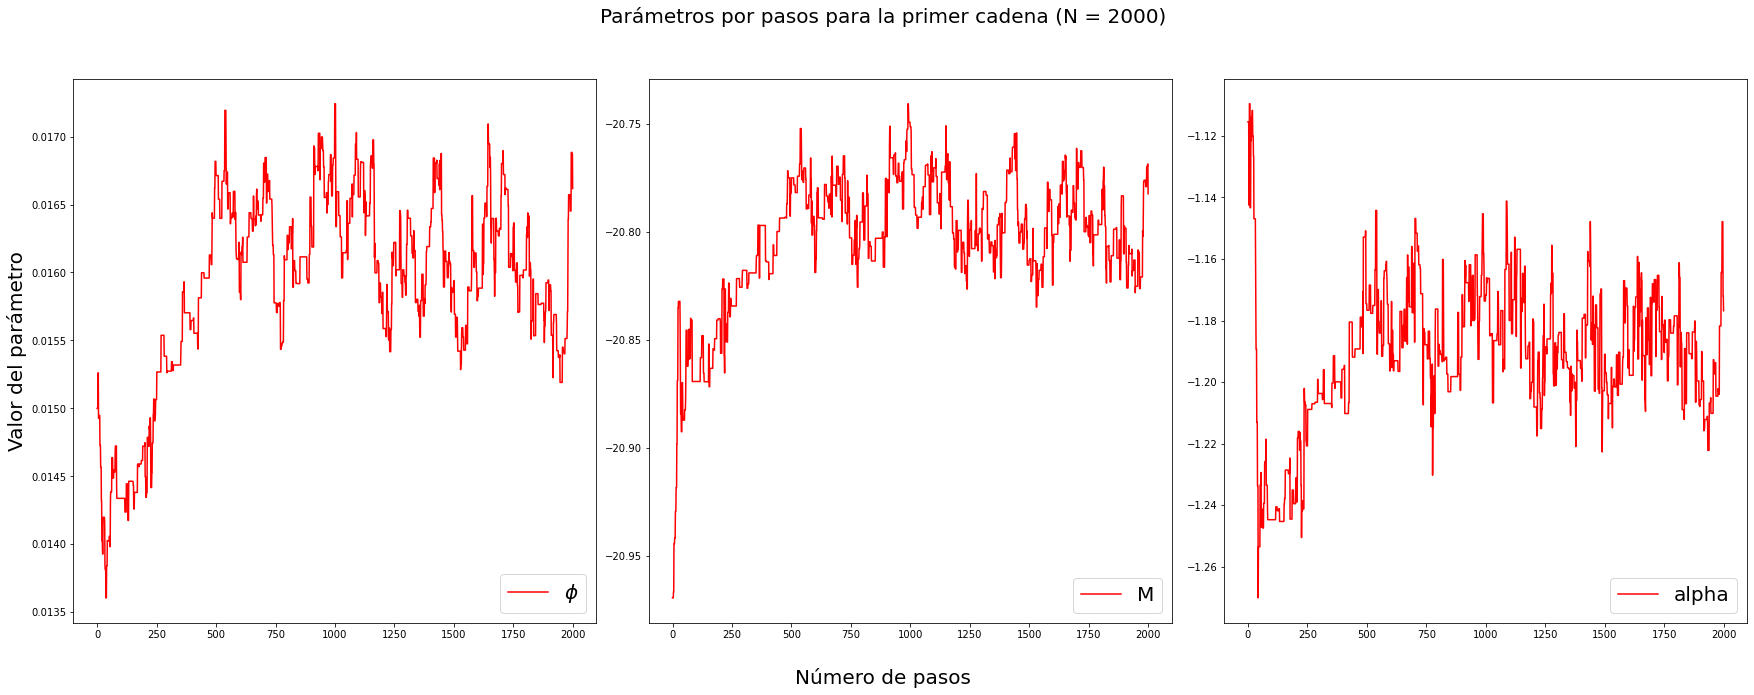

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Parámetros por pasos para la primer cadena (N = 2000)', fontsize=20)


ax1.plot(listas_phi[0], label = '$\phi$', c = 'red')
ax1.legend(loc = 'lower right',fontsize=20)
ax1.set_ylabel('Valor del parámetro', fontsize = 20)

ax2.plot(listas_M[0], label = 'M', c = 'red')
ax2.legend(loc = 'lower right',fontsize=20)

ax3.plot(listas_alpha[0], label = 'alpha', c = 'red')
ax3.legend(loc = 'lower right',fontsize=20)

fig.text(0.5, 0.04, 'Número de pasos', ha='center',fontsize=20)
fig.subplots_adjust(wspace=0.1)
plt.show()

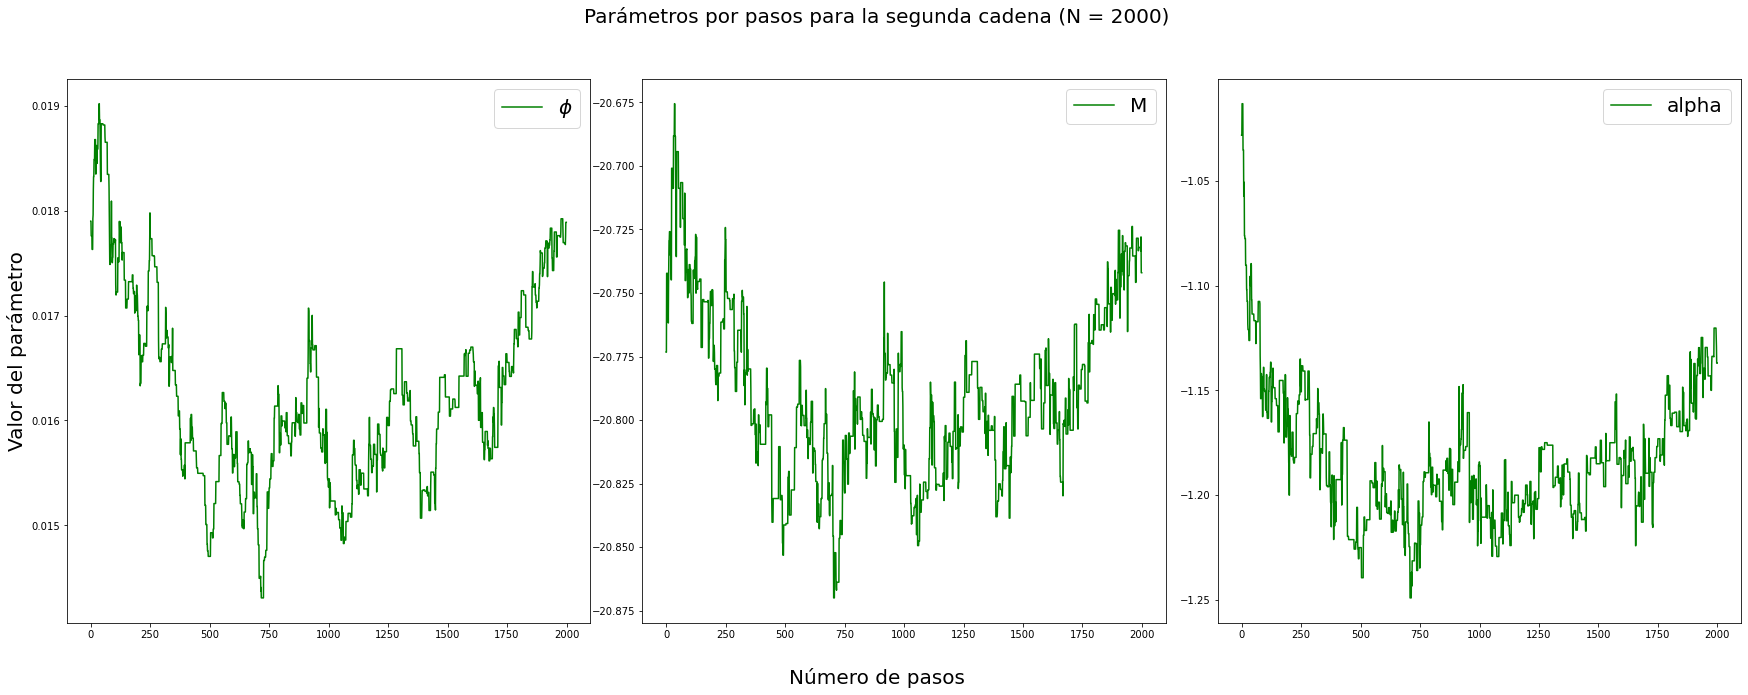

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Parámetros por pasos para la segunda cadena (N = 2000)', fontsize=20)


ax1.plot(listas_phi[1], label = '$\phi$', c = 'green')
ax1.legend(loc = 'upper right',fontsize=20)
ax1.set_ylabel('Valor del parámetro', fontsize = 20)

ax2.plot(listas_M[1], label = 'M', c = 'green')
ax2.legend(loc = 'upper right',fontsize=20)

ax3.plot(listas_alpha[1], label = 'alpha', c = 'green')
ax3.legend(loc = 'upper right',fontsize=20)

fig.text(0.5, 0.04, 'Número de pasos', ha='center',fontsize=20)
fig.subplots_adjust(wspace=0.1)
plt.show()

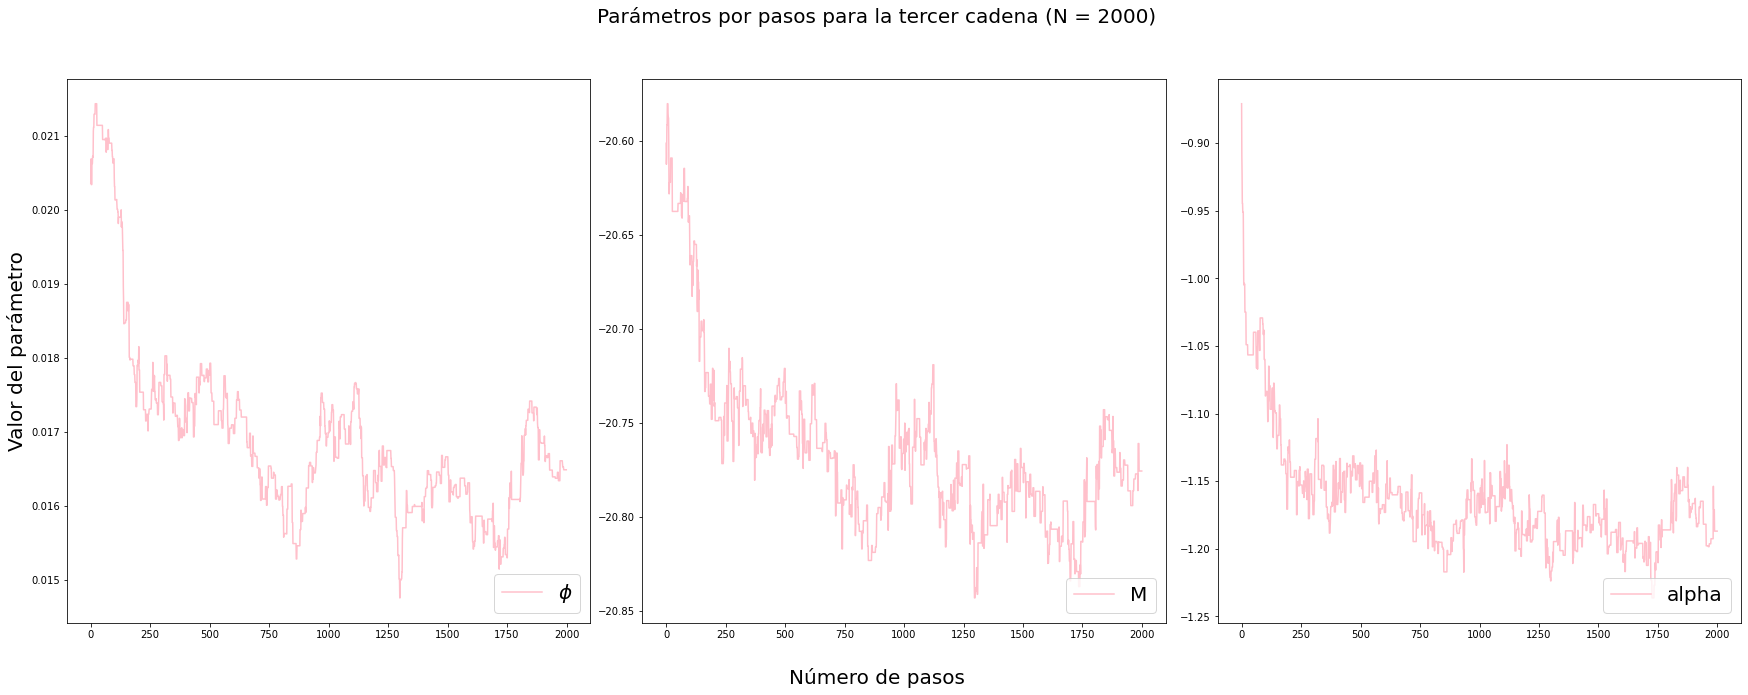

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Parámetros por pasos para la tercer cadena (N = 2000)', fontsize=20)


ax1.plot(listas_phi[2], label = '$\phi$', c = 'pink')
ax1.legend(loc = 'lower right',fontsize=20)
ax1.set_ylabel('Valor del parámetro', fontsize = 20)

ax2.plot(listas_M[2], label = 'M', c = 'pink')
ax2.legend(loc = 'lower right',fontsize=20)

ax3.plot(listas_alpha[2], label = 'alpha', c = 'pink')
ax3.legend(loc = 'lower right',fontsize=20)

fig.text(0.5, 0.04, 'Número de pasos', ha='center',fontsize=20)
fig.subplots_adjust(wspace=0.1)
plt.show()

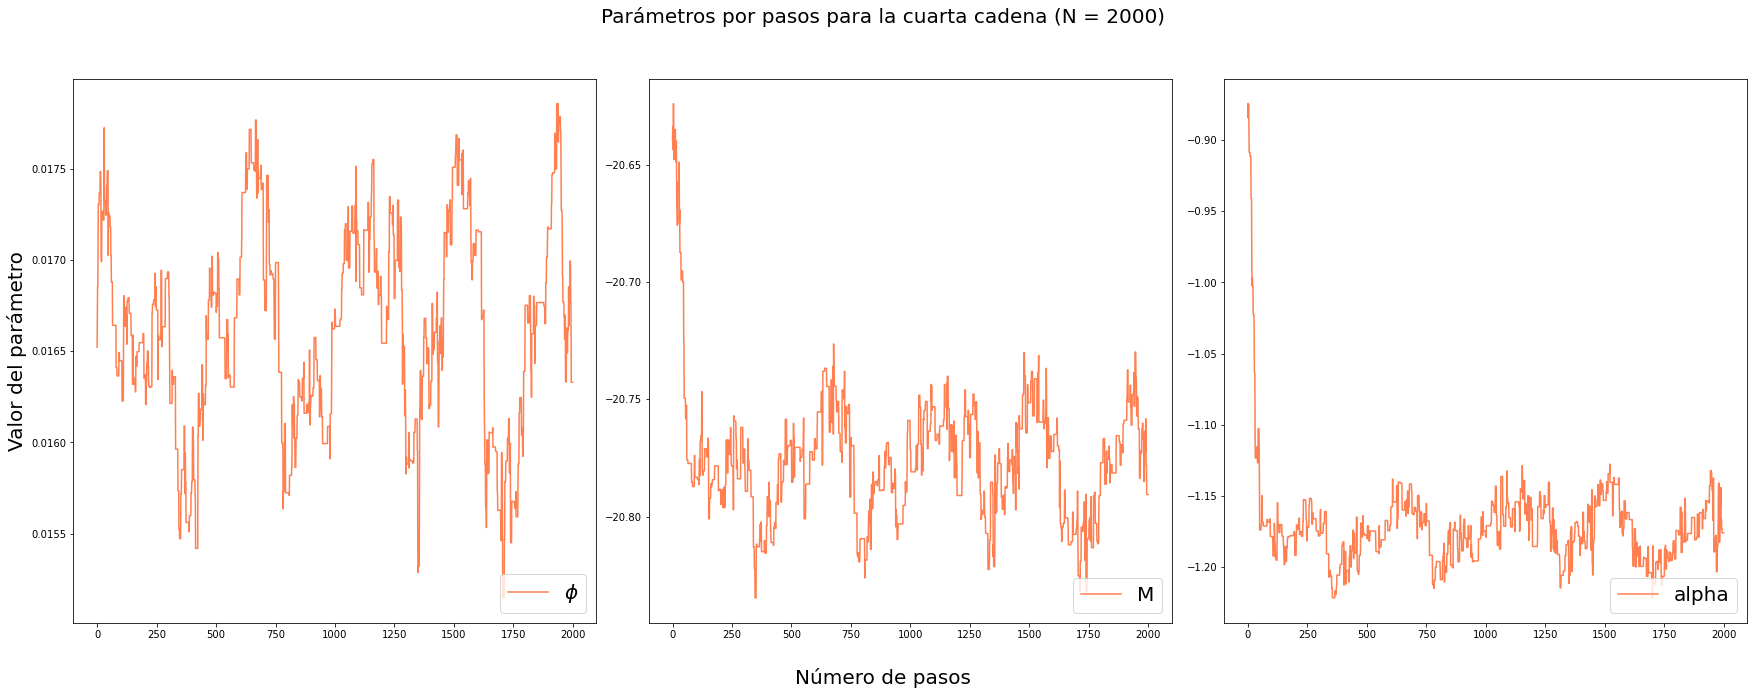

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Parámetros por pasos para la cuarta cadena (N = 2000)', fontsize=20)


ax1.plot(listas_phi[3], label = '$\phi$', c = 'coral')
ax1.legend(loc = 'lower right',fontsize=20)
ax1.set_ylabel('Valor del parámetro', fontsize = 20)

ax2.plot(listas_M[3], label = 'M', c = 'coral')
ax2.legend(loc = 'lower right',fontsize=20)

ax3.plot(listas_alpha[3], label = 'alpha', c = 'coral')
ax3.legend(loc = 'lower right',fontsize=20)

fig.text(0.5, 0.04, 'Número de pasos', ha='center',fontsize=20)
fig.subplots_adjust(wspace=0.1)
plt.show()

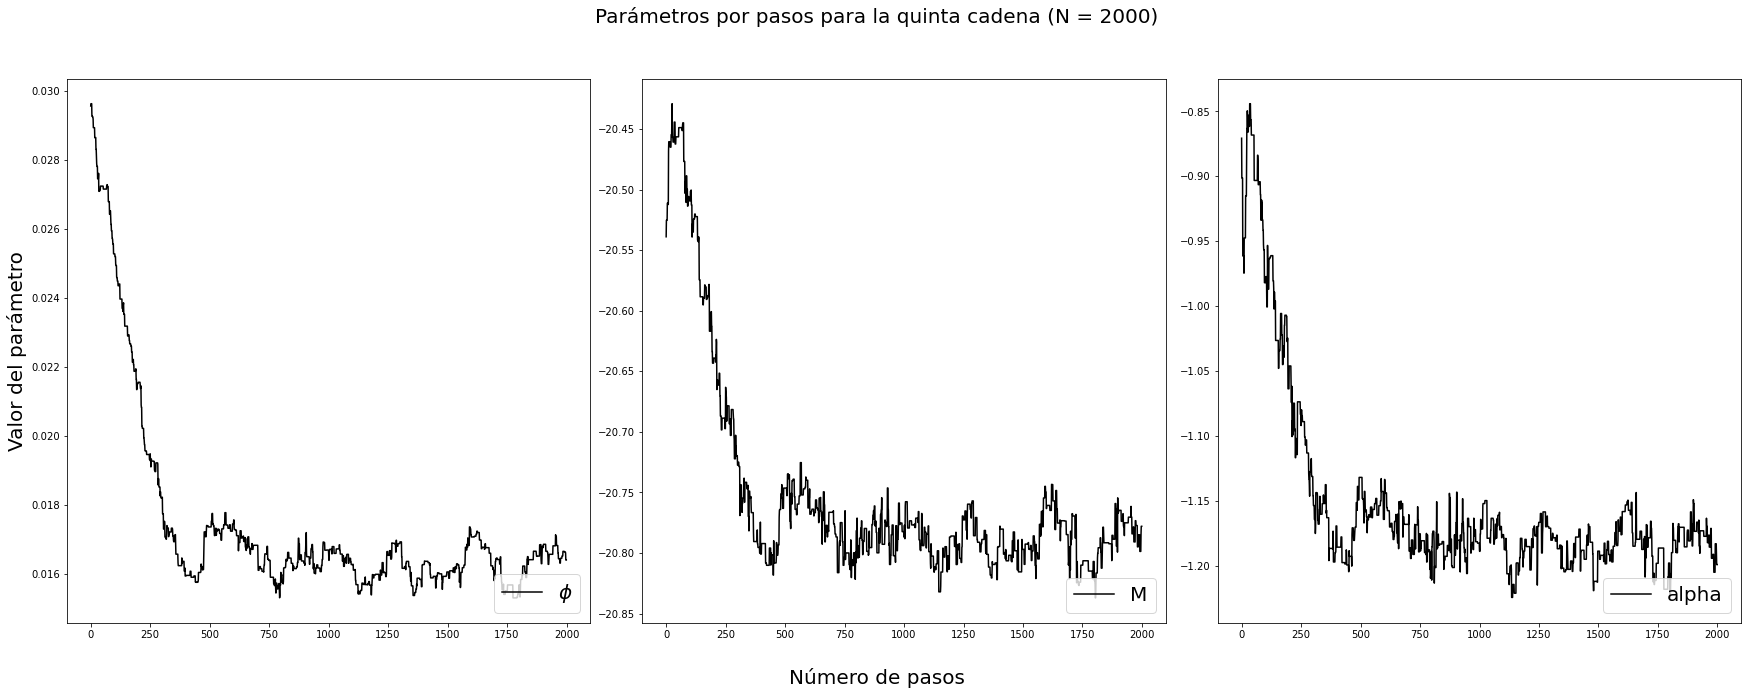

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Parámetros por pasos para la quinta cadena (N = 2000)', fontsize=20)


ax1.plot(listas_phi[4], label = '$\phi$', c = 'black')
ax1.legend(loc = 'lower right',fontsize=20)
ax1.set_ylabel('Valor del parámetro', fontsize = 20)

ax2.plot(listas_M[4], label = 'M', c = 'black')
ax2.legend(loc = 'lower right',fontsize=20)

ax3.plot(listas_alpha[4], label = 'alpha', c = 'black')
ax3.legend(loc = 'lower right',fontsize=20)

fig.text(0.5, 0.04, 'Número de pasos', ha='center',fontsize=20)
fig.subplots_adjust(wspace=0.1)
plt.show()

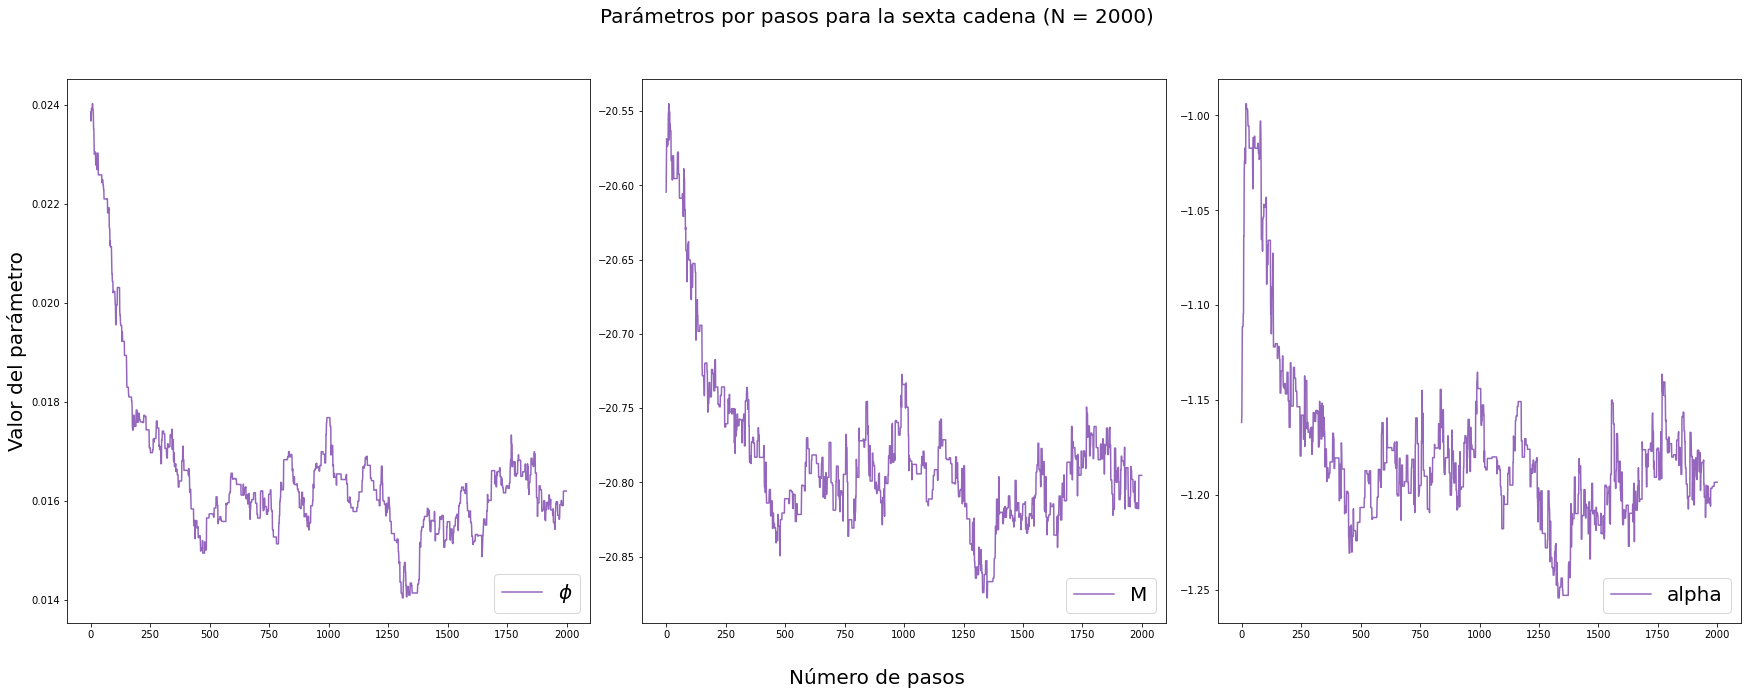

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Parámetros por pasos para la sexta cadena (N = 2000)', fontsize=20)


ax1.plot(listas_phi[5], label = '$\phi$', c = 'C4')
ax1.legend(loc = 'lower right',fontsize=20)
ax1.set_ylabel('Valor del parámetro', fontsize = 20)

ax2.plot(listas_M[5], label = 'M', c = 'C4')
ax2.legend(loc = 'lower right',fontsize=20)

ax3.plot(listas_alpha[5], label = 'alpha', c = 'C4')
ax3.legend(loc = 'lower right',fontsize=20)

fig.text(0.5, 0.04, 'Número de pasos', ha='center',fontsize=20)
fig.subplots_adjust(wspace=0.1)
plt.show()

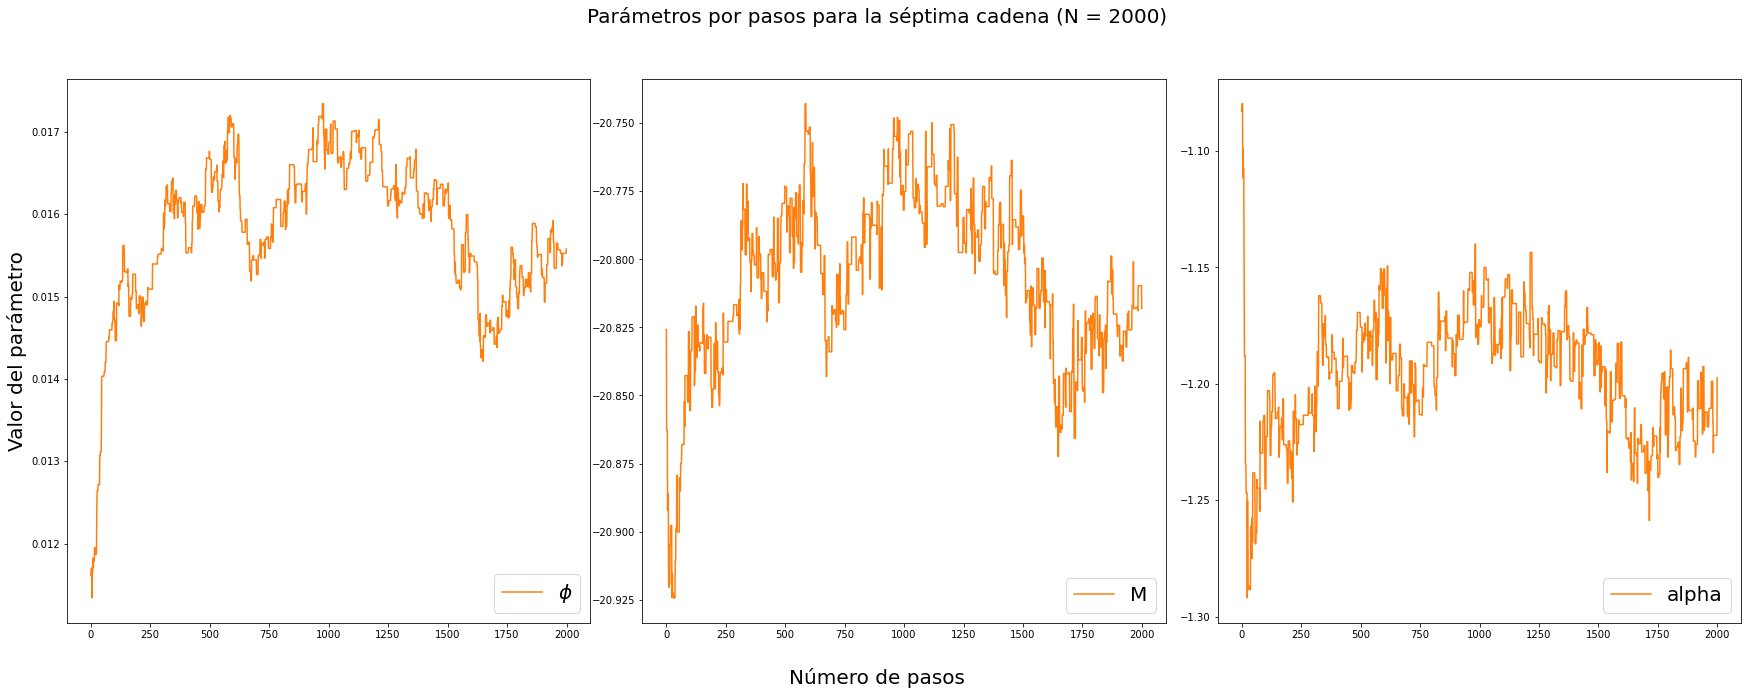

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Parámetros por pasos para la séptima cadena (N = 2000)', fontsize=20)


ax1.plot(listas_phi[6], label = '$\phi$', c = 'C1')
ax1.legend(loc = 'lower right',fontsize=20)
ax1.set_ylabel('Valor del parámetro', fontsize = 20)

ax2.plot(listas_M[6], label = 'M', c = 'C1')
ax2.legend(loc = 'lower right',fontsize=20)

ax3.plot(listas_alpha[6], label = 'alpha', c = 'C1')
ax3.legend(loc = 'lower right',fontsize=20)

fig.text(0.5, 0.04, 'Número de pasos', ha='center',fontsize=20)
fig.subplots_adjust(wspace=0.1)
plt.show()

### Inciso 4

Implemente el método de gradiente descendente para encontrar el mı́nimo de Likelihood marginalizado a cada
uno de los parámetros. Discuta posibles cuestiones de precisión, conveniencias e inconveniencias del método.

Comenzamos definiendo $\chi$:

In [25]:
def chi(phi0,M0,alpha0):
    y_modelo = modelo(phi0,x_lista,M0,alpha0)
    y_datos = y_lista
    chi = 0
    sigma = barra_inf + barra_sup
    for i in range(len(y_modelo)):
        chi = ((y_datos[i] - y_modelo[i])**2)/sigma[i] + chi
    return(chi)

Probamos con los parámetros de Blantos para ver si funciona bien (que nos devuelva algo)

In [26]:
chi(1.46e-2,-20.83,-1.20)

0.08782015386953454

Ahora hacemos variar los valores de los parámetros para ver donde es mínimo el $\chi$ (los mejores parámetros se encuentran donde $\chi$ es mínimo)

In [27]:
N = 100
_X = np.linspace(4e-4,2.5e-2,N)  #phi entre 1e-4 y 5e-2
_Y = np.linspace(-22,-19,N)    #M entre -22 y -19
_W = np.linspace(-2.5,0.9,N)    #alpha entre -2.5 y -0.9
_Z1 = np.zeros((N,N))
_Z2 = np.zeros((N,N))
_Z3 = np.zeros((N,N))

for ix,x in enumerate(_X):
    for iy,y in enumerate(_Y):
        if chi(x,y,-1.20) < 3:
            _Z1[iy,ix]=chi(x,y,-1.20)
        else:
            _Z1[iy,ix]=np.nan
                        
for ix,x in enumerate(_X):
    for iw,w in enumerate(_W):
        if chi(x,-20.83,w) < 5.:
            _Z2[iw,ix]=chi(x,-20.83,w)
        else:
            _Z2[iw,ix]=np.nan
            
for iw,w in enumerate(_W):
    for iy,y in enumerate(_Y):
        if chi(1.46e-2,y,w)<3:
            _Z3[iy,iw]=chi(1.46e-2,y,w)
        else:
            _Z3[iy,iw]=np.nan

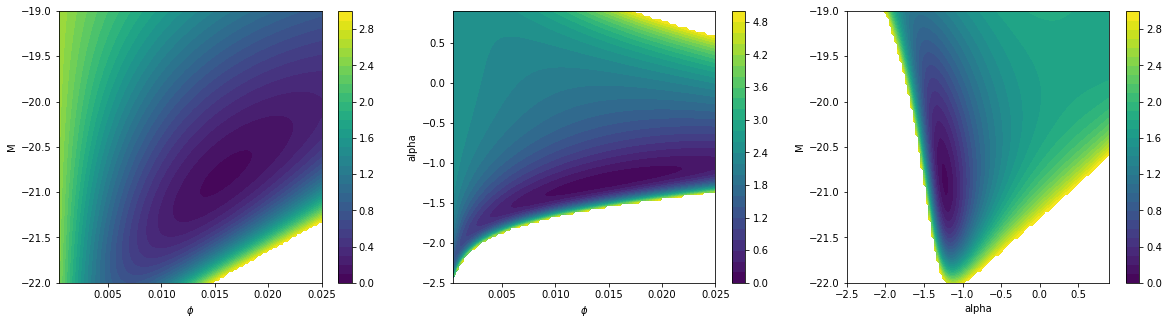

In [28]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.contourf(_X,_Y,_Z1,100,levels=30)
plt.colorbar()
plt.ylabel('M')
plt.xlabel('$\phi$')

plt.subplot(1, 3, 2)
plt.contourf(_X,_W,_Z2,100,levels=30)
plt.colorbar()
plt.ylabel('alpha')
plt.xlabel('$\phi$')

plt.subplot(1, 3, 3)
plt.contourf(_W,_Y,_Z3,100, levels = 30)
plt.colorbar()
plt.ylabel('M')
plt.xlabel('alpha')

plt.show()

Se puede ver que las regiones oscuras de los gráficos (donde $\chi$ es mínimo) se corresponden con valores de los parámetros de Blanton, como esperabamos.
Ahora procedemos a calcular las derivadas para armar los pasos del gradiente descendiente.

In [29]:
def dphi(phi0,M0,alpha0):   #derivada de phi(M) con respecto a phi*
    l_phi = []
    y = modelo(phi0,x_lista,M0,alpha0)
    for i in range(len(y)):
        dphi = y[i]/phi0
        l_phi.append(dphi)
    return(l_phi)

In [30]:
def dM(phi0,M0,alpha0):   #derivada de phi(M) con respecto a M*
    l_M = []
    A = np.array(x_lista)
    
    for i in range(len(A)):
        B = 0.4 * np.log(10) * phi0
        C = np.log(10) * 0.4 * (alpha0+1) * (10**(-0.4*(A[i]-M0)*(alpha0 + 1))) * np.exp(10**(-0.4*(A[i]-M0)))
        D = 10**(-0.4*(A[i]-M0)*(alpha0 + 1)) * 0.4 * np.exp(-0.4*(A[i]-M0)) * 10**(-0.4*(A[i]-M0))
        dM = B * (C - D)
        l_M.append(dM)
    return(l_M)

In [32]:
def dalpha(phi0,M0,alpha0):   #derivada de phi(M) con respecto a alpha*
    l_alpha = []
    y = modelo(phi0,x_lista,M0,alpha0)
    for i in range(len(y)):
        dalpha = y[i]*np.log(10)*(-0.4)*(x_lista[i]-M0)
        l_alpha.append(dalpha)
    return(l_alpha)

In [34]:
def gradiente(phi0,M0,alpha0):  #gradiente de phi(M)
    dchi_dphi = 0
    dchi_dM = 0
    dchi_dalpha = 0
    
    y_modelo = modelo(phi0,x_lista,M0,alpha0)
    y_datos = y_lista
    sigma = barra_inf + barra_sup
    
    d_phi = dphi(phi0,M0,alpha0)
    d_M = dM(phi0,M0,alpha0)
    d_alpha = dalpha(phi0,M0,alpha0)
    
    for i in range(len(y_modelo)):
        dchi_dphi = dchi_dphi -( 2*((y_datos[i] - y_modelo[i])/sigma[i]) *d_phi[i])
        dchi_dM = dchi_dM - (2*((y_datos[i] - y_modelo[i])/sigma[i])* d_M[i])
        dchi_dalpha = dchi_dalpha - (2*((y_datos[i] - y_modelo[i])/sigma[i]) * d_alpha[i])
        
    return(np.array([dchi_dphi,dchi_dM,dchi_dalpha]))

Para ver si funciona, calculamos el gradiente de la función $\chi(\phi^*,M^*,\alpha^*)$ en el punto $\phi^* = 0.02$, $M^* = -21.5$ y $\alpha^* = -1.2$ (lo dejamos fijo). Según el gráfico hecho arriba, este punto se corresponde donde $\phi(M)$ es mayor. Por lo tanto, se espera que $\vec{\nabla \chi}$ tenga dirección contraria al mínimo.

In [35]:
gradiente(0.02,-21.5,-1.2)   

array([364.56945852, -65.09632853, -10.14846996])

La dirección es contraria al crecimiento de $M^*$ y a favor del de $\phi^*$, un resultado esperado según lo que muestra el gráfico de $\chi$

Ejecutamos los pasos para el gradiente descendiente 
<center>
$ \vec{a_{new}} = \vec{a_{old}} - \eta \vec{\nabla \chi}$
</center>

In [160]:
def grad_desc(eta,pasos):

    grad = np.array([0,0,0])

    while grad.any() < 1e-8:

        M0_old = random.uniform(-21.9,-19.1)
        phi0_old = random.uniform(4e-4,4e-2)
        alpha0_old = random.uniform(-1.9,-1e-4)

        grad = gradiente(phi0_old,M0_old,alpha0_old)

    c_phi0 = [phi0_old] #guardo los parámetors iniciales
    c_M0 = [M0_old]
    c_alpha0 = [alpha0_old]

    for i in range(pasos):
        #calculamos los parámetros nuevos
        phi0_old = phi0_old - eta * grad[0] * (1e-1)
        M0_old = M0_old - eta * grad[1] * (1.5e-1)
        alpha0_old = alpha0_old - eta * grad[2] 
        
        grad = gradiente(phi0_old,M0_old,alpha0_old)

        c_phi0.append(phi0_old)
        c_M0.append(M0_old)
        c_alpha0.append(alpha0_old)
    
    return(c_phi0,c_M0, c_alpha0)

In [204]:
gd = grad_desc(0.0002,30)

In [205]:
gd

([0.025052269154677013,
  0.023017000853169326,
  0.021593148862985103,
  0.02059453646773341,
  0.019892986148079838,
  0.019399512698918802,
  0.019052027231337424,
  0.0188070721627913,
  0.018634170787093677,
  0.018511923481849494,
  0.018425292679598606,
  0.01836370656049648,
  0.018319730929681307,
  0.018288137371560372,
  0.018265248686820664,
  0.018248478766093933,
  0.01823600899863737,
  0.01822656064421216,
  0.018219234690891876,
  0.018213399188280327,
  0.01820860998495482,
  0.01820455497104923,
  0.018201014860217603,
  0.018197835608758286,
  0.01819490902183017,
  0.018192159118782882,
  0.01818953254906408,
  0.018186991856571015,
  0.018184510746740448,
  0.018182070761511897,
  0.018179658943809435],
 [-20.938353420839412,
  -20.937409376542774,
  -20.936662257587457,
  -20.936039665237534,
  -20.93549810043226,
  -20.93501046163125,
  -20.934559358841376,
  -20.93413336946616,
  -20.93372485344141,
  -20.933328630322904,
  -20.93294115189647,
  -20.93255997027

Veamos si los nuevos parámetros calculados se acercan a los de Blanton.

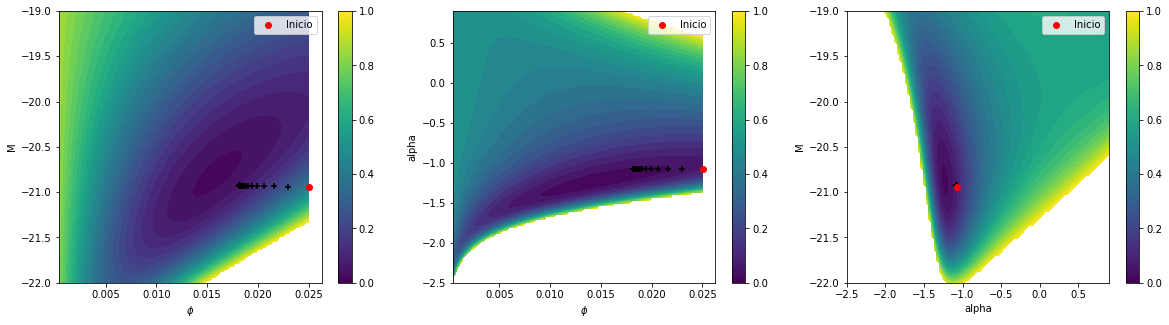

In [206]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.contourf(_X,_Y,_Z1,100,levels=30)
plt.scatter(gd[0], gd[1],marker = '+', c = 'black')
plt.scatter(gd[0][0], gd[1][0],c='red', label = 'Inicio')
plt.colorbar()
plt.ylabel('M')
plt.xlabel('$\phi$')
plt.legend()

plt.subplot(1, 3, 2)
plt.contourf(_X,_W,_Z2,100,levels=30)
plt.scatter(gd[0], gd[2],marker = '+',c='black')
plt.scatter(gd[0][0], gd[2][0],c='red', label = 'Inicio')
plt.colorbar()
plt.ylabel('alpha')
plt.xlabel('$\phi$')
plt.legend()

plt.subplot(1, 3, 3)
plt.contourf(_W,_Y,_Z3,100, levels = 30)
plt.scatter(gd[2], gd[1],marker = '+',c = 'black')
plt.scatter(gd[2][0], gd[1][0],c='red', label = 'Inicio')
plt.colorbar()
plt.ylabel('M')
plt.xlabel('alpha')
plt.legend()

plt.show()

Comparemos la curva del modelo con algunas curvas con estos nuevos parámetros

In [208]:
y1 = modelo(gd[0][-1],x_lista,gd[1][-1],gd[2][-1])  #curva con los parámetros del paso 31

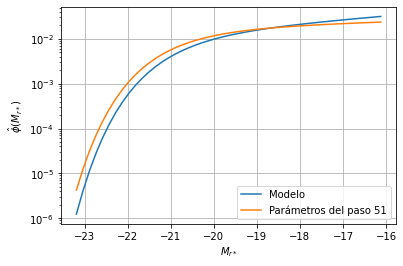

In [209]:
plt.plot(x_lista,y,label='Modelo')
plt.plot(x_lista,y1,label='Parámetros del paso 31')
#plt.plot(x_lista,y2,label='Parámetros del paso 50')
#plt.plot(x_lista,y3,label='Parámetros del paso 49')
plt.yscale('log')
plt.ylabel('$\hat{\phi} (M_{r*})$')
plt.xlabel('$M_{r*}$')
plt.legend()
plt.grid()

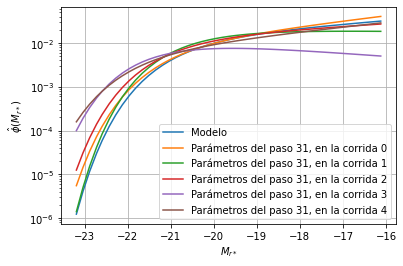

In [264]:
N = 5
plt.plot(x_lista,y,label='Modelo')
for i in range(N):
    gd = grad_desc(0.0002,30)
    y1 = modelo(gd[0][-1],x_lista,gd[1][-1],gd[2][-1])
    plt.plot(x_lista,y1,label='Parámetros del paso 31, en la corrida '+str(i))
    plt.yscale('log')
    plt.ylabel('$\hat{\phi} (M_{r*})$')
    plt.xlabel('$M_{r*}$')
    plt.legend()
    plt.grid()

Después de haber corrido el código muchas veces, notamos que la gran mayoría de las veces los valores que nos devuelven no son buenos, pero una pequeña parte si. Entre esos resultados, se graficaron los últimos obtenidos por el método, que en algunos casos resultan ser bastantes acertados.
La razón de por qué el código construido tiene este problema puede deberse al reescalado de la taza de aprendizaje en cada parámetro. Evidentemente el $\eta$ es muy sensible en algunos parámetros y no tanto en otros, por lo que se hace dificil encontrar una buena configuración en la que el código funcione de manera más óptima.